# Unupervised-Learning - Exercise Sheet 8

## General Setup/ Imports

In [260]:
import numpy as np
from math import sqrt, cos, sin, radians
import matplotlib.pyplot as plt
from scipy.stats import chi2

## Task 2

### 1. Sampeling

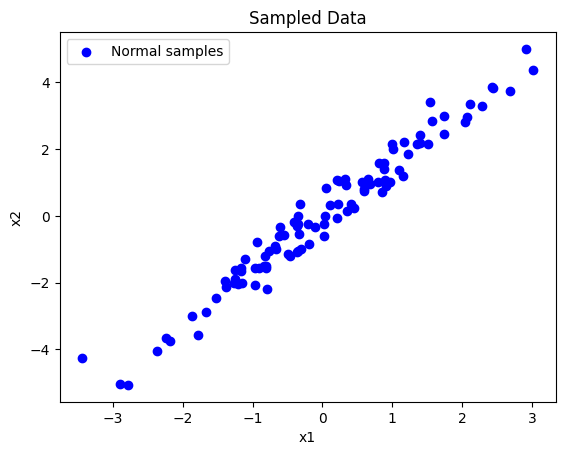

In [261]:
#Building the covariance matrix
sigX2, sigY2 = 2, 1
rho = sqrt(3)/2
sigX, sigY = sqrt(sigX2), sqrt(sigY2)

Sigma = np.array([
    [sigX2, sigX2 + rho*sigX*sigY],
    [sigX2 + rho*sigX*sigY, sigX2 + sigY2 + 2*rho*sigX*sigY]
], dtype=float)

# since the mean is not specified we use (0,0) 
mean = np.array([0,0])
rng = np.random.default_rng(42)   # set seed
samples = rng.multivariate_normal(mean, Sigma, size=100)

plt.scatter(samples[:,0], samples[:,1], color="blue", label="Normal samples")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Sampled Data")
plt.legend()
plt.show()

### 2. Calculate Eigenvector

In [262]:
eigvals, eigvecs = np.linalg.eigh(Sigma)   # ascending
v1 = eigvecs[:, 1]                         # largest eigenvalue
print(eigvals, v1)                         # v1 already normalized

[0.06773457 7.38175517] [0.51399075 0.85779573]


### 3. Add Outliers

In [263]:
def rot(theta):
    t = radians(theta)
    return np.array([[cos(t), -sin(t)],
                     [sin(t),  cos(t)]], dtype=float)

Sigma_sqrt = eigvecs @ np.diag(np.sqrt(eigvals)) @ eigvecs.T

outliers = []
for q in (0.99, 0.995, 0.999):
    c_q = chi2.ppf(q, df=2)
    for theta in (+10.0, -10.0): 
        u = rot(theta) @ v1
        u = u / np.linalg.norm(u)          # normalized unit direction
        x_out = mean + sqrt(c_q) * (Sigma_sqrt @ u)
        outliers.append(x_out)

outliers = np.array(outliers)  # shape (6, 2)
print(outliers)

[[4.05607925 7.03600789]
 [4.29138207 6.89501456]
 [4.35063425 7.54696715]
 [4.60302491 7.3957348 ]
 [4.96766226 8.61731457]
 [5.25584818 8.44463372]]


### 4. Plot Outliers and Analyse

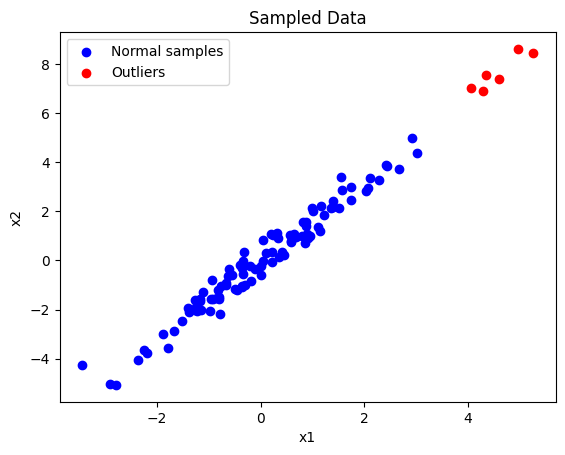

In [264]:
plt.scatter(samples[:,0], samples[:,1], color="blue", label="Normal samples")
plt.scatter(outliers[:,0], outliers[:,1], color="red", label="Outliers")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Sampled Data")
plt.legend()
plt.show()

#### Observation
The outliers are generated at high Mahalanobis distances with respect to the distribution of the data and placed along directions close to the principal eigenvector of the covariance matrix, obtained by rotating it by 10°. This means that the outliers lie far from the bulk of the data while still being aligned with the main direction of variability, as can be seen in the scatter plot.

#### Impact
The outliers have a strong leverage effect, substantially increasing the empirical variance and covariance, particularly along the main direction of variability. However, since they are approximately aligned with this direction, they mainly inflate the scale of the distribution while leaving the direction of maximal variance largely unchanged.




## Task 4

### 1. Parametric Outlier Detection

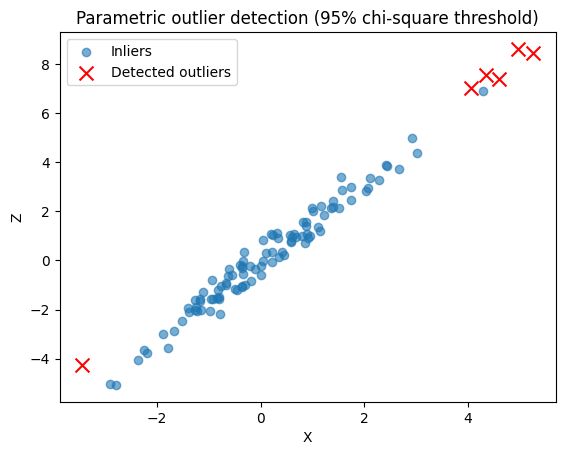

In [265]:
data_with_outliers = np.vstack((samples, outliers))

x_bar = data_with_outliers.mean(axis=0)

# Naive covariance with Bessel correction
A = np.cov(data_with_outliers, rowvar=False, bias=False)

# Squared Mahalanobis distances
A_inv = np.linalg.inv(A)
diffs = data_with_outliers - x_bar
d2 = np.einsum("ij,jk,ik->i", diffs, A_inv, diffs)

# 95% chi-square threshold
threshold = chi2.ppf(0.95, df=2)

# Flag outliers
outlier_mask = d2 > threshold
outlier_indices = np.where(outlier_mask)[0]
data_cleaned = data_with_outliers[~outlier_mask]


# Plott 
plt.scatter(
    data_with_outliers[~outlier_mask, 0],
    data_with_outliers[~outlier_mask, 1],
    alpha=0.6,
    label="Inliers"
)
plt.scatter(
    data_with_outliers[outlier_mask, 0],
    data_with_outliers[outlier_mask, 1],
    color="red",
    marker="x",
    s=100,
    label="Detected outliers"
)

plt.xlabel("X")
plt.ylabel("Z")
plt.legend()
plt.title("Parametric outlier detection (95% chi-square threshold)")
plt.show()


### 2. Mahalanobis Distances with naive Covariance

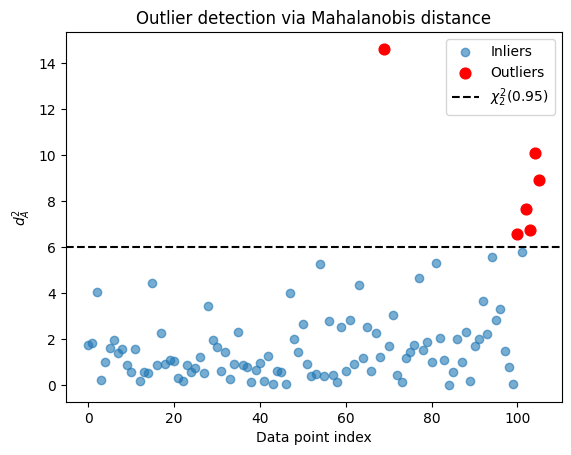

In [266]:
plt.figure()

plt.scatter(
    np.where(~outlier_mask)[0],
    d2[~outlier_mask],
    alpha=0.6,
    label="Inliers"
)

plt.scatter(
    np.where(outlier_mask)[0],
    d2[outlier_mask],
    color="red",
    s=60,
    label="Outliers"
)

plt.axhline(
    threshold,
    color="black",
    linestyle="--",
    label=r"$\chi^2_2(0.95)$"
)

plt.xlabel("Data point index")
plt.ylabel(r"$d^2_A$")
plt.legend()
plt.title("Outlier detection via Mahalanobis distance")
plt.show()


### 3. Remove outliers and recompute the covariance

In [267]:
# recompute mean (optional but useful for later tasks)
x_bar_clean = data_cleaned.mean(axis=0)

# recompute cleaned covariance C' with Bessel correction
C_prime = np.cov(data_cleaned, rowvar=False, bias=False)

print("Cleaned mean x̄':", x_bar_clean)
print("Cleaned covariance C':\n", C_prime)

Cleaned mean x̄': [0.10819985 0.1397806 ]
Cleaned covariance C':
 [[1.79234912 2.86531129]
 [2.86531129 4.73659577]]


### 4. Recompute Distances and analysis of new outliers

The Covariance Matrix is computed based on the cleaned data. After that the new covariance matrix is used for outlier detection on the entire dataset (including the previous identiefied otliers).

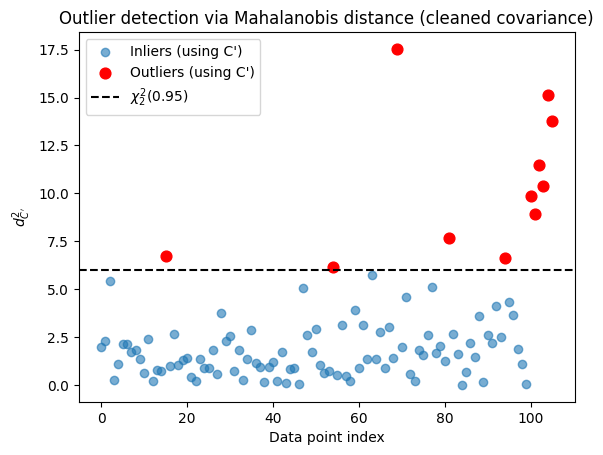

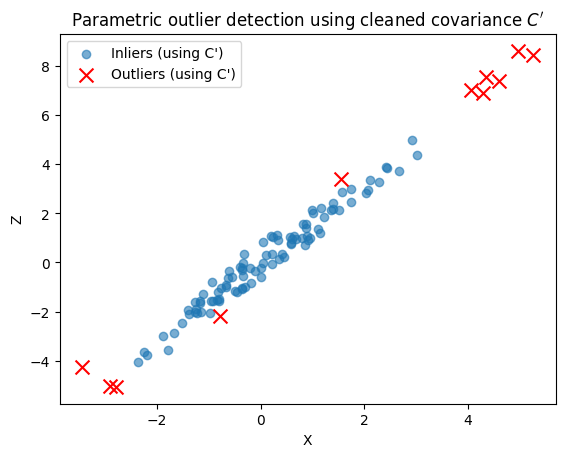

In [268]:
# inverse of cleaned covariance
C_inv = np.linalg.inv(C_prime)

# squared Mahalanobis distances using C'
diffs = data_with_outliers - x_bar
d2_C = np.einsum("ij,jk,ik->i", diffs, C_inv, diffs)

# 95% chi-square threshold
threshold = chi2.ppf(0.95, df=2)

# newly flagged points
outlier_mask_C = d2_C > threshold
outlier_indices_C = np.where(outlier_mask_C)[0]


# Visualisation
plt.figure()

plt.scatter(
    np.where(~outlier_mask_C)[0],
    d2_C[~outlier_mask_C],
    alpha=0.6,
    label="Inliers (using C')"
)

plt.scatter(
    np.where(outlier_mask_C)[0],
    d2_C[outlier_mask_C],
    color="red",
    s=60,
    label="Outliers (using C')"
)

plt.axhline(
    threshold,
    color="black",
    linestyle="--",
    label=r"$\chi^2_2(0.95)$"
)

plt.xlabel("Data point index")
plt.ylabel(r"$d^2_{C'}$")
plt.legend()
plt.title("Outlier detection via Mahalanobis distance (cleaned covariance)")
plt.show()

# Visualization like parametric outlier detection (above)
plt.scatter(
    data_with_outliers[~outlier_mask_C, 0],
    data_with_outliers[~outlier_mask_C, 1],
    alpha=0.6,
    label="Inliers (using C')"
)

plt.scatter(
    data_with_outliers[outlier_mask_C, 0],
    data_with_outliers[outlier_mask_C, 1],
    color="red",
    marker="x",
    s=100,
    label="Outliers (using C')"
)

plt.xlabel("X")
plt.ylabel("Z")
plt.legend()
plt.title("Parametric outlier detection using cleaned covariance $C'$")
plt.show()

#### Comment


After recomputing the Mahalanobis distances using the cleaned covariance matrix C', all manually added outliers from Task 2 are correctly identified. In addition, several further observations are now classified as outliers, since removing the extreme points reduces the covariance estimate and increases the sensitivity of the distance measure, causing moderate deviations that were previously masked to exceed the fixed 95% threshold. Overall, we identify five additional natural outliers besides the six manually added ones, which is consistent with the expected proportion of approximately 5% in a sample of size 100.


### 5. Compute Delta and quantify using Norms

In [272]:

print("A\n", A)
print("C'\n", C_prime)

Delta = A - C_prime

# Frobenius norm
Delta_fro = np.linalg.norm(Delta, ord="fro")

# Operator norm: largest singular value
Delta_op = np.linalg.norm(Delta, ord=2)

print("Delta = A - C' =\n", Delta)
print("||Delta||_* (operator norm) =", Delta_op)
print("||Delta||_F (Frobenius norm) =", Delta_fro)


eigvals, eigvecs = np.linalg.eigh(Delta)  # for symmetric matrices; returns ascending eigenvalues

print("\n----------\nEigenvalues (ascending):")
print(eigvals)
print("\nEigenvectors (columns correspond to eigenvalues):")
print(eigvecs)


A
 [[2.76635047 4.4606366 ]
 [4.4606366  7.36533702]]
C'
 [[1.79234912 2.86531129]
 [2.86531129 4.73659577]]
Delta = A - C' =
 [[0.97400135 1.5953253 ]
 [1.5953253  2.62874124]]
||Delta||_* (operator norm) = 3.5984811564041035
||Delta||_F (Frobenius norm) = 3.5984836796634334

----------
Eigenvalues (ascending):
[0.00426143 3.59848116]

Eigenvectors (columns correspond to eigenvalues):
[[-0.85451424  0.51942796]
 [ 0.51942796  0.85451424]]


### Observations and how they can be explained by our choice of outliers
**(1) What the norms measure.**  
For a symmetric matrix, the Frobenius norm equals the square root of the sum of squared eigenvalues and therefore measures the total magnitude of the deviation across all directions. In contrast, the operator norm equals the largest absolute eigenvalue and highlights the strongest deviation in a single direction, corresponding to the maximal directional distortion of the covariance matrix.

**(2) Interpretation of the observations.**  
In our setting, the operator norm and the Frobenius norm of Delta = A - C' take almost identical values. This indicates that the deviation between the naive covariance matrix A and the cleaned covariance matrix C' is dominated by a single direction rather than being spread evenly across multiple directions. The largest differences appears the direction (0.52, 0.85) (the eigenvector of the larger Eigenvalue)

**(3) Relation to the outlier construction.**  
This behavior is a direct consequence of how the outliers were constructed. The outliers were placed close to the principal axis of the data distribution and far from the mean, which concentrates their influence along one dominant direction. As a result, the difference matrix Delta is effectively low-rank, causing both the operator norm and the Frobenius norm to reveal nearly the same magnitude of deviation. If the outliers had instead been distributed across several directions, the Frobenius norm would have captured a larger overall deviation relative to the operator norm, thereby revealing different aspects of the covariance change.


